In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch import distributions
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, HTML

In [2]:
device = torch.device('cpu') #'cuda' if torch.cuda.is_available() else 

# Normalising flows: comparison to CNF
In this notebook we compare the performance of CNF to a normalising flow with a similar architecture. As with the CNF example, we will learn a two-modal distribution with two concentric circles, and a uniform distribution of a triangle.
## Hyperparameters

In [3]:
args = {
    'niters': 5000,
    'lr': 1e-4,
    'num_samples': 1000,
}

## The Model

We will use a normalising flow with the following architecture, so it is similar to that of the CNF:
- 10 layers
- Hypernet with 2 hidden layers to generate the parameters of the affine transformation
- Affine transformation

The hypernet is conditioned on the context, which is the same as the CNF.

In [4]:
class CouplingLayer(nn.Module):
    def __init__(self, in_out_dim, hidden_dim, mask, num_layers):
        super(CouplingLayer, self).__init__()
        
        self.mask = nn.Parameter(mask.to(device), requires_grad=False)
        
        self.scale = nn.Sequential( # s network
            nn.Linear(in_out_dim, hidden_dim),
            nn.LeakyReLU(),
            *[nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LeakyReLU(),
            ) for _ in range(num_layers)],
            nn.Linear(hidden_dim, in_out_dim),
            nn.Tanh(),
        )
        
        self.translation = nn.Sequential( # t network
            nn.Linear(in_out_dim, hidden_dim),
            nn.LeakyReLU(),
            *[nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LeakyReLU(),
            ) for _ in range(num_layers)],
            nn.Linear(hidden_dim, in_out_dim),
        )
        
    def forward(self, x):
        masked_x = x * self.mask
        scale = self.scale(masked_x)*(1 - self.mask)
        translation = self.translation(masked_x)*(1 - self.mask)
        
        x = masked_x + (1 - self.mask) * (x * torch.exp(scale) + translation)        
        return x
    
    def inverse(self, x):
        masked_x = self.mask * x
        scale = self.scale(masked_x)*(1 - self.mask)
        translation = self.translation(masked_x)*(1 - self.mask)
        x = (1 - self.mask) * (x - translation) * torch.exp(-scale) + masked_x
        log_det = scale.sum(dim=1)
        return x, log_det
    

            

In [5]:
class NF(nn.Module):
    """RealNVP model with spatial checkerboard mask."""
    
    def __init__(self, in_out_dim, hidden_dim, num_layers, num_transformations):
        super(NF, self).__init__()
        
        self.prior = distributions.MultivariateNormal(torch.zeros(in_out_dim).to(device), torch.eye(in_out_dim).to(device))
        
        mask_even = torch.from_numpy(np.array([0., 1.]).astype(np.float32)).to(device)
        mask_odd = torch.from_numpy(np.array([1., 0.]).astype(np.float32)).to(device)
        
        self.transformations = torch.nn.ModuleList([
            CouplingLayer(in_out_dim, hidden_dim, mask_even if i % 2 == 0 else mask_odd, num_layers)
            for i in range(num_transformations)
        ] )
        
    def inverse(self, x):
        #print("inverse")
        log_det, z = x.new_zeros(x.shape[0]), x
        for i, transform in enumerate(reversed(self.transformations)):
            #print("z shape: ", z.shape)
            z, delta_log_det = transform.inverse(z)
            #print("delta:",delta_log_det.shape)
            #print("log_Det:",log_det.shape)
            log_det -= delta_log_det
        return z, log_det
    
    def log_prob(self, x):
        #print("log_prob")
        z, logp = self.inverse(x)
        return self.prior.log_prob(z) + logp
    
    def sample(self, num_samples):
        #print("sample")
        z = self.prior.sample((num_samples,))
        for transform in self.transformations:
            z = transform.forward(z)
        return z
    
    def sample_progressive(self, samples, trans_i):
        #print("sample_progressive")
        z = self.transformations[trans_i].forward(samples)
        return z
        

## Traingular distribution

In [6]:
def point_on_triangle(pt1, pt2, pt3):
    """
    Random point on the triangle with vertices pt1, pt2 and pt3.
    """
    x, y = random.random(), random.random()
    q = abs(x - y)
    s, t, u = q, 0.5 * (x + y - q), 1 - 0.5 * (q + x + y)
    return (
        s * pt1[0] + t * pt2[0] + u * pt3[0],
        s * pt1[1] + t * pt2[1] + u * pt3[1],
    )


def get_batch(num_samples):
    """
    Generate random points uniformly distributed inside a custom triangle.
    """
    pt1 = [-0.2, 0.0]
    pt2 = [0.6, 0.0]
    pt3 = [0.0, 0.7]

    # Generate random points inside the triangle
    points = [point_on_triangle(pt1, pt2, pt3) for _ in range(num_samples)]

    x = torch.tensor(points).type(torch.float32)
    return x

## Define the model

In [7]:
model_triangle = NF(in_out_dim=2, hidden_dim=256, num_layers=5, num_transformations=10).to(device)
optimizer_triangle = optim.Adam([p for p in model_triangle.parameters() if p.requires_grad == True], lr=args['lr'])
print("The model has {} trainable parameters".format(sum(p.numel() for p in model_triangle.parameters() if p.requires_grad)))

The model has 6604840 trainable parameters


## Train the model

In [8]:
def train_nf(model, optimizer):
    for i in range(1,args['niters']+1):
        sample = get_batch(args['num_samples']).to(device)
        loss = -model.log_prob(sample).mean()
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        if i % 100 == 0:
            print(f'Iter {i}, Loss: {loss.item()}')
            
#train_nf(model_triangle, optimizer_triangle)

## Plot the results

In [9]:
def viz_nf(model, results_dir,  viz_samples=30000):
    target = get_batch(viz_samples).cpu()
    
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
        
    with torch.no_grad():
        # Generate evolution of samples
        current_sample = model.prior.sample((viz_samples,)).cpu()
        
        # Create plot for each transformation
        for i in range(len(model.transformations)):
            fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
            plt.suptitle(f'Transformation {i+1}')
            plt.tight_layout()
            
            current_sample = model.cpu().sample_progressive(current_sample, i).cpu()
            
            axes[0].set_title('Target')
            axes[0].hist2d(*target.detach().cpu().numpy().T, bins=300, density=True, range=[[-1.5, 1.5], [-1.5, 1.5]])
            
            axes[1].set_title('Model')
            axes[1].hist2d(*current_sample.detach().cpu().numpy().T, bins=300, density=True, range=[[-1.5, 1.5], [-1.5, 1.5]])
            
            file_number = str(i + 1).zfill(len(str(len(model.transformations))))
            plt.savefig(os.path.join(results_dir, f'nf-viz-{file_number}.png'))
            plt.close()
            
        # Display GIF
        gif_imgs = [os.path.join(results_dir, f) for f in os.listdir(results_dir) if f.endswith('.png')]
        img, *imgs = [Image.open(img) for img in gif_imgs]
        gif_path = os.path.join(results_dir, "nf-viz.gif")
        img.save(fp=gif_path, format='GIF', append_images=imgs, save_all=True, duration=250, loop=0)
        display(HTML(f'<img src="{gif_path}" width="{1000}">'))
        img.close()
        for im in imgs:
            im.close()

#viz_nf(model_triangle, 'triangle_results')


In [20]:
# Plot final result
def nf_final(model, viz_samples = 30000):
    model = model.to(device)
    target = get_batch(viz_samples).to(device)
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), dpi=200)
    plt.suptitle(f'Final result')
    plt.tight_layout()
    
    x = np.linspace(-1.5, 1.5, 100)
    y = np.linspace(-1.5, 1.5, 100)
    points = np.vstack(np.meshgrid(x, y)).reshape([2, -1]).T
    points = torch.tensor(points).type(torch.float32).to(device)
    
    trans_sample = model.sample(viz_samples).to(device)
    logp = model.log_prob(points)
    
    axes[0].set_title('Target')
    axes[0].hist2d(*target.detach().cpu().numpy().T, bins=300, density=True, range=[[-1.5, 1.5], [-1.5, 1.5]])
    
    axes[1].set_title('Model')
    axes[1].hist2d(*trans_sample.detach().cpu().numpy().T, bins=300, density=True, range=[[-1.5, 1.5], [-1.5, 1.5]])
    
    axes[2].set_title("Model's density")
    # Set x-axis and y-axis limits
    axes[2].set_xlim(-1.5, 1.5)
    axes[2].set_ylim(-1.5, 1.5)
    axes[2].tricontourf(*points.detach().cpu().numpy().T, np.exp(logp.detach().cpu().numpy()), 200)

    
    plt.show()
    del model
    
#nf_final(model_triangle)

### Concentric circles

In [11]:
from sklearn.datasets import make_circles
def get_batch(num_samples):
    """
    Generate random points in a two concentric circles distribution.
    """
    points, _ = make_circles(n_samples=num_samples, noise=0.06, factor=0.5)
    x = torch.tensor(points).type(torch.float32)
    return x

#### Define the model

In [16]:
model_circles = NF(in_out_dim=2, hidden_dim=256, num_layers=4, num_transformations=14).to(device)
optimizer_circles = optim.Adam([p for p in model_circles.parameters() if p.requires_grad == True], lr=args['lr'])
print("The model has {} trainable parameters".format(sum(p.numel() for p in model_circles.parameters() if p.requires_grad)))

The model has 7404600 trainable parameters


#### Train the model

In [17]:
train_nf(model_circles, optimizer_circles)

Iter 100, Loss: 1.5280535221099854
Iter 200, Loss: 1.3115547895431519
Iter 300, Loss: 1.1889710426330566
Iter 400, Loss: 1.1762127876281738
Iter 500, Loss: 1.0896005630493164
Iter 600, Loss: 1.0436482429504395
Iter 700, Loss: 1.0484206676483154
Iter 800, Loss: 0.9744402170181274
Iter 900, Loss: 0.984395444393158
Iter 1000, Loss: 1.0058344602584839
Iter 1100, Loss: 1.0345864295959473
Iter 1200, Loss: 0.9909207820892334
Iter 1300, Loss: 0.9435001611709595
Iter 1400, Loss: 1.0386090278625488
Iter 1500, Loss: 0.9609430432319641
Iter 1600, Loss: 0.9741714000701904
Iter 1700, Loss: 0.9820248484611511
Iter 1800, Loss: 0.9567689299583435
Iter 1900, Loss: 0.9009305238723755
Iter 2000, Loss: 0.9472805857658386
Iter 2100, Loss: 1.0866564512252808
Iter 2200, Loss: 1.0827271938323975
Iter 2300, Loss: 0.9821907877922058
Iter 2400, Loss: 0.9825799465179443
Iter 2500, Loss: 1.0596606731414795
Iter 2600, Loss: 0.9566640257835388
Iter 2700, Loss: 0.8900377750396729
Iter 2800, Loss: 0.9491429328918457
It

#### Plot the results

In [18]:
viz_nf(model_circles, 'circles_results_2')

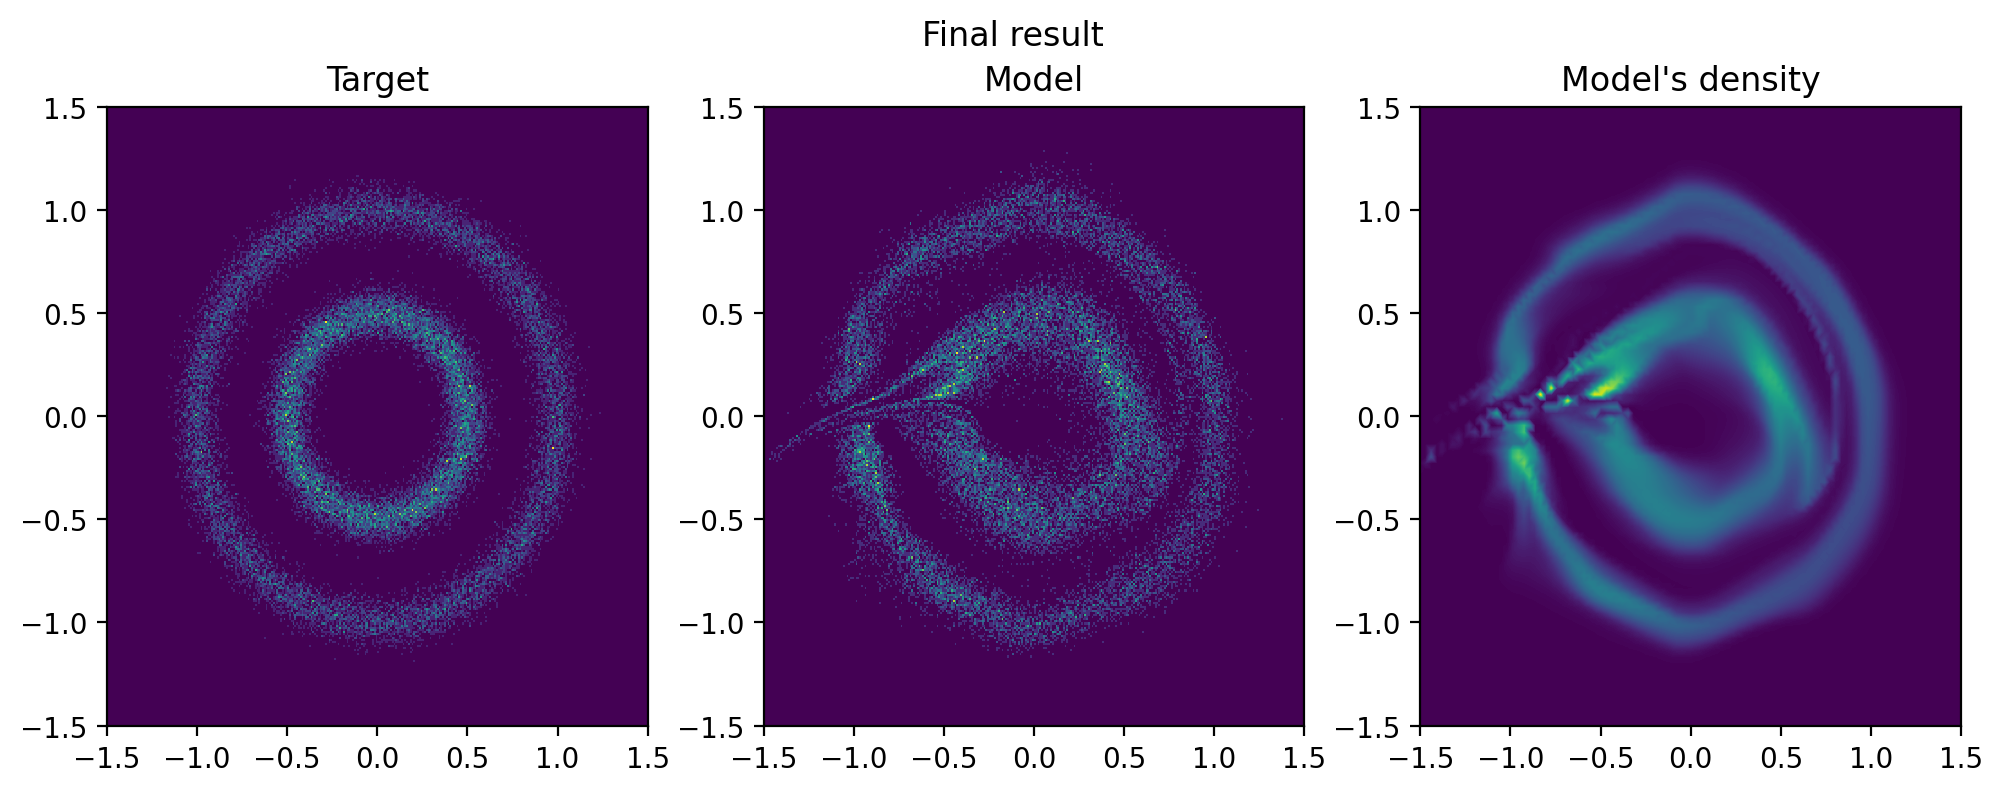

In [21]:
nf_final(model_circles)

## Comparison
### 